<a href="https://colab.research.google.com/github/410921209/big-data/blob/main/Bigdata1218.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas
!pip install seaborn
!pip install matplotlib
!pip install scikit-learn

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import accuracy_score,classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
from sklearn.tree import export_graphviz
from IPython.display import Image
from google.colab import drive
drive.mount('/content/drive') # 連結至Google雲端硬碟

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
Data = pd.read_csv("/content/drive/MyDrive/big_data/Disaster_process.csv")
ch_county = ["臺北市","新北市","基隆市","新竹市","桃園市","新竹縣","宜蘭縣",
      "臺中市","苗栗縣","彰化縣","南投縣","雲林縣",
      "高雄市","臺南市","嘉義市","嘉義縣","屏東縣","澎湖縣",
      "花蓮縣","臺東縣",
      "金門縣","連江縣","其他或無"]
ch_disaster = ["火災","化學災害","一氧化碳中毒","交通事故","地震","山域事故","災害救助","其他"]
county_dict = {ch_county[i] : i for i in range(len(ch_county))}
disaster_dict = {ch_disaster[i] : i for i in range(len(ch_disaster))}
casualty_level_dict = {"無傷亡" : 0 ,"死亡" : 2 ,"無生命徵象" : 2 ,"一氧化碳中毒" : 1 ,"高山症" : 1 ,"輕重傷" : 1 ,"意識不清" : 1 }
detailed_disaster_dict = {Data["災情"].unique()[i] : i for i in range(len(Data["災情"].unique()))}
Data_copy = Data.copy()
Data_copy['Casualty'] = Data_copy['Casualty'].apply(str)

#Entropy v.s. Gini

In [4]:
def find_criterion(X,y):
  DT = DecisionTreeClassifier(random_state = 42)
  score_gini = cross_val_score(DT,X,y,cv=10).mean()

  DT = DecisionTreeClassifier(criterion = 'entropy',random_state = 42)
  score_entropy = cross_val_score(DT,X,y,cv=10).mean()
  criterion = 'gini' if score_gini > score_entropy else 'entropy'
  return criterion

def find_Max_depth(X,y,criterion):
  ScoreAll = []
  for i in range(1,10):
    DT = DecisionTreeClassifier(max_depth = i,criterion = criterion,random_state = 42)
    score = cross_val_score(DT,X,y,cv=10).mean()
    ScoreAll.append([i,score])
  ScoreAll = np.array(ScoreAll)

  max_score = np.where(ScoreAll==np.max(ScoreAll[:,1]))[0][0] #找出最高得分对应的索引
  max_depth = int(ScoreAll[max_score][0])
  return max_depth

def find_Min_samples_split(X,y,criterion,max_depth):
  ScoreAll = []
  for i in range(2,71):
    DT = DecisionTreeClassifier(min_samples_split = i,max_depth = max_depth,criterion = criterion,random_state = 42)
    score = cross_val_score(DT,X,y,cv=10).mean()
    ScoreAll.append([i,score])
  ScoreAll = np.array(ScoreAll)

  max_score = np.where(ScoreAll==np.max(ScoreAll[:,1]))[0][0] #找出最高得分对应的索引
  min_samples_split = int(ScoreAll[max_score][0])
  return min_samples_split

def find_Min_samples_leaf(X,y,criterion,max_depth,min_samples_split):
  ScoreAll = []
  for i in range(1,21):
    DT = DecisionTreeClassifier(min_samples_leaf = i,min_samples_split = min_samples_split,max_depth = max_depth,criterion = criterion,random_state = 42)
    score = cross_val_score(DT,X,y,cv=10).mean()
    ScoreAll.append([i,score])
  ScoreAll = np.array(ScoreAll)

  max_score = np.where(ScoreAll==np.max(ScoreAll[:,1]))[0][0] #找出最高得分对应的索引
  min_samples_leaf = int(ScoreAll[max_score][0])
  return min_samples_leaf

In [5]:
df = Data_copy[["Disaster",'Detailed disaster',"County","Year","Month","Weekday","Hour","Casualty"]]
df = df[(df['Year']!=2023) | (df['Month']!=12)]
X = df[['Disaster', 'Detailed disaster', 'County', 'Year', 'Month','Weekday','Hour']]
y = df['Casualty']

Criterion = find_criterion(X,y)
Max_depth = find_Max_depth(X,y,Criterion)
Min_samples_split = find_Min_samples_split(X,y,Criterion,Max_depth)
Min_samples_leaf = find_Min_samples_leaf(X,y,Criterion,Max_depth,Min_samples_split)

決策樹(gini)：


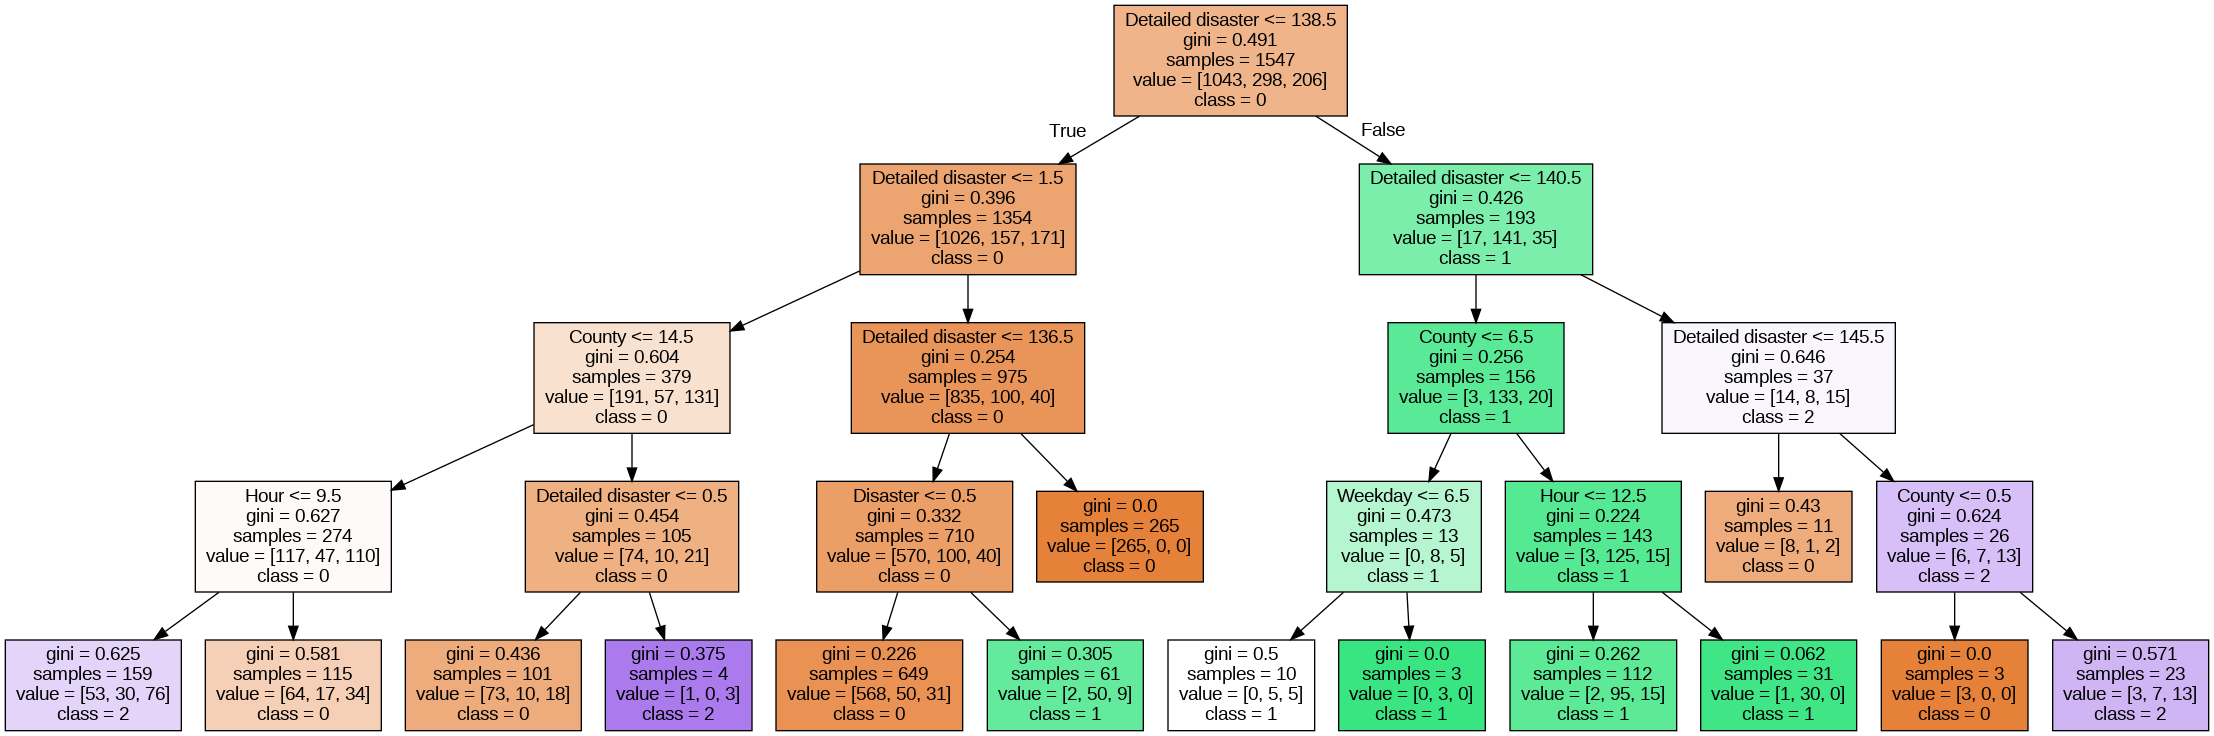

In [6]:
df = Data_copy[["Disaster","Detailed disaster","County","Year","Month","Weekday","Hour","Casualty"]]
df_train = df[(df['Year'] != 2023) | (df['Month'] != 12)]
df_test = df[(df['Year'] == 2023) & (df['Month'] == 12)]


X_train = df_train[['Disaster', 'Detailed disaster', 'County', 'Year', 'Month', 'Weekday','Hour']]
y_train = df_train['Casualty']
X_test = df_test[['Disaster', 'Detailed disaster', 'County', 'Year', 'Month', 'Weekday','Hour']]
y_test = df_test['Casualty']

x_cols = X_train.columns.tolist()
clf = DecisionTreeClassifier(criterion = Criterion,max_depth=Max_depth, min_samples_leaf = Min_samples_leaf,min_samples_split = Min_samples_split)


clf.fit(X_train, y_train)

export_graphviz(clf,out_file='DT.dot',filled=True,feature_names=x_cols, class_names=sorted(df['Casualty'].unique(),key = int))
!dot -Tpng DT.dot > DT.png
print('決策樹('+Criterion+')：')
Image('DT.png')

#GridSearchCV

In [7]:
df = Data_copy[["Disaster",'Detailed disaster',"County","Year","Month","Weekday","Hour","Casualty"]]
df = df[(df['Year']!=2023) | (df['Month']!=12)]
X = df[['Disaster', 'Detailed disaster', 'County', 'Year', 'Month','Weekday','Hour']]
y = df['Casualty']

param_grid = {
    'criterion': ['entropy','gini'],
    'max_depth':[i for i in range(4,8)],
    'min_samples_leaf':[i for i in range(1,6)],
    'min_samples_split':[i for i in range(10,150,10)]
    }

rfc = DecisionTreeClassifier(random_state=42)
GS = GridSearchCV(rfc,param_grid,cv=10)
GS.fit(X,y)
print(GS.best_params_)
print(GS.best_score_)

{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 120}
0.789388353581902


決策樹(gini)：


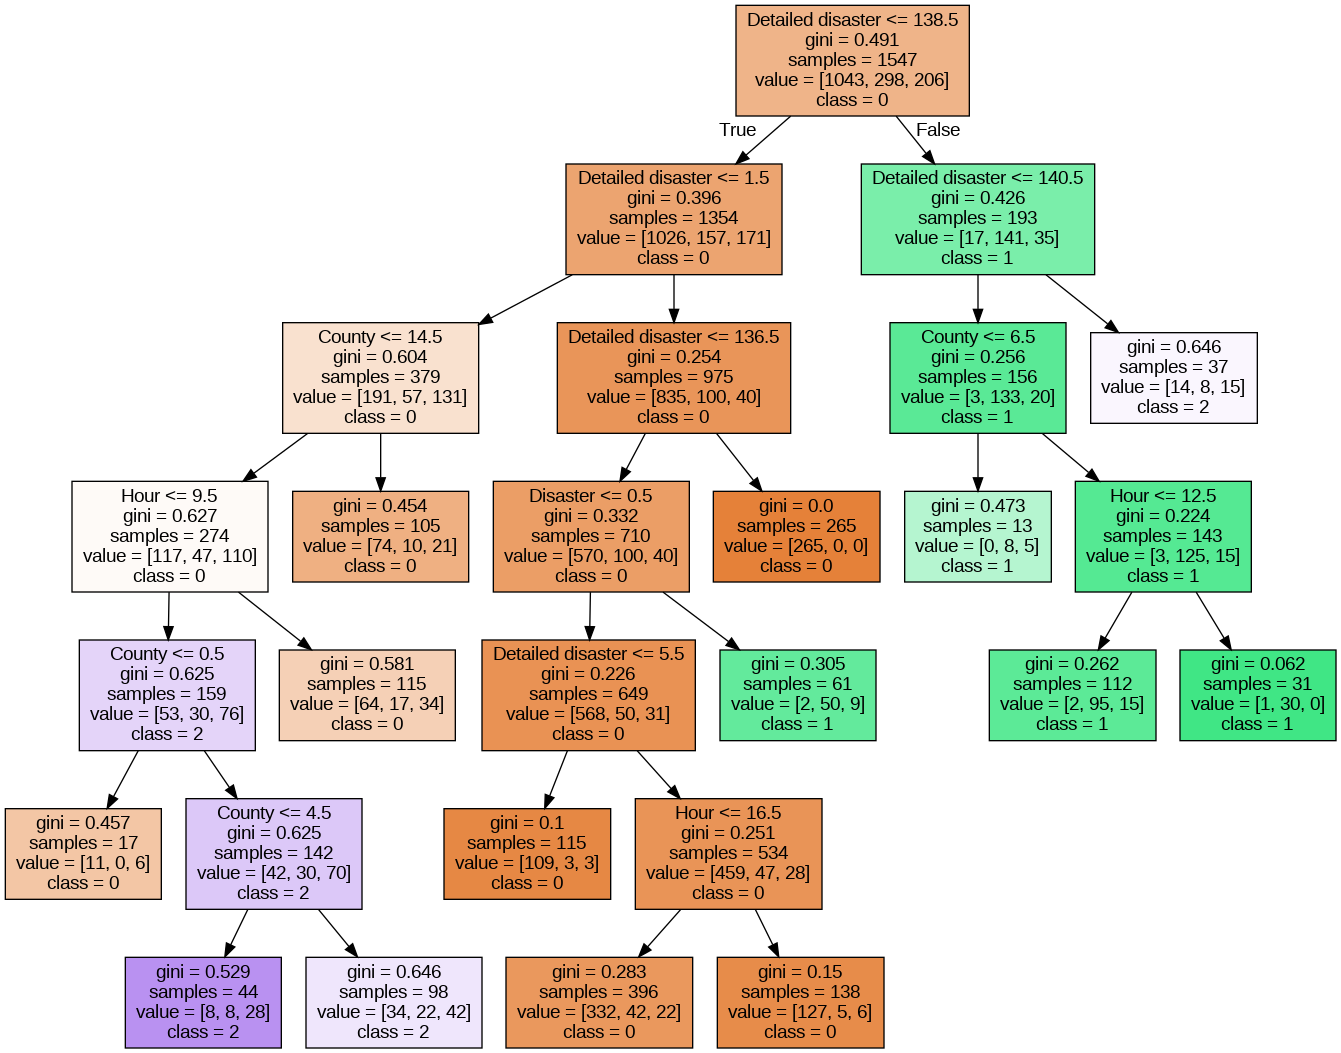

In [8]:
GS_df = Data_copy[["Disaster","Detailed disaster","County","Year","Month","Weekday","Hour","Casualty"]]

GS_df_train = GS_df[(GS_df['Year'] != 2023) | (GS_df['Month'] != 12)]
GS_df_test = GS_df[(GS_df['Year'] == 2023) & (GS_df['Month'] == 12)]

GS_X_train = GS_df_train[['Disaster', 'Detailed disaster', 'County', 'Year', 'Month', 'Weekday','Hour']]
GS_y_train = GS_df_train['Casualty']
GS_X_test = GS_df_test[['Disaster', 'Detailed disaster', 'County', 'Year', 'Month', 'Weekday','Hour']]
GS_y_test = GS_df_test['Casualty']
GS_x_cols = GS_X_train.columns.tolist()

GS_clf = GS.best_estimator_
GS_clf.fit(GS_X_train, GS_y_train)

export_graphviz(GS_clf,out_file='DT.dot',filled=True,feature_names=GS_x_cols, class_names=sorted(GS_df['Casualty'].unique(),key = int))
!dot -Tpng DT.dot > DT.png
print('決策樹('+GS.best_estimator_.criterion+')：')
Image('DT.png')

# **預測12月的傷亡情況**


In [10]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

print("\n -  -  -  -  -  -  -    GridSearchCV    -  -  -  -  -  -  -  \n")
GS_y_pred = GS_clf.predict(GS_X_test)
print(classification_report(GS_y_test, GS_y_pred))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90        23
           1       0.50      0.25      0.33         4
           2       0.25      0.20      0.22         5

    accuracy                           0.75        32
   macro avg       0.53      0.47      0.48        32
weighted avg       0.71      0.75      0.72        32


 -  -  -  -  -  -  -    GridSearchCV    -  -  -  -  -  -  -  

              precision    recall  f1-score   support

           0       0.81      0.96      0.88        23
           1       0.50      0.25      0.33         4
           2       0.33      0.20      0.25         5

    accuracy                           0.75        32
   macro avg       0.55      0.47      0.49        32
weighted avg       0.70      0.75      0.71        32

